# Линейные преобразования и апрроксимация данных

Будем изучать профили NACA. Основную информацию по ним можно взять с сайта
http://airfoiltools.com/

Нас будет интересовать профиль
<a href="http://airfoiltools.com/airfoil/naca4digit?MNaca4DigitForm%5Bcamber%5D=2&MNaca4DigitForm%5Bposition%5D=40&MNaca4DigitForm%5Bthick%5D=12&MNaca4DigitForm%5BnumPoints%5D=81&MNaca4DigitForm%5BcosSpace%5D=0&MNaca4DigitForm%5BcosSpace%5D=1&MNaca4DigitForm%5BcloseTe%5D=0&yt0=Plot"> NACA 4 digit airfoil</a> (можно взять любой другой с этого сайта).

Будем использовать библиотеки `numpy`, `scipy`, `matpolib`.

1. NumPy https://numpy.org/
2. SciPy https://scipy.org/
3. Matplotlib https://matplotlib.org/

Импортируем необходимые библиотеки.

In [71]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from IPython.display import display, Math, Latex

## Параметризация профиля

Возьмите с сайта (<a href="http://airfoiltools.com/airfoil/naca4digit?MNaca4DigitForm%5Bcamber%5D=2&MNaca4DigitForm%5Bposition%5D=40&MNaca4DigitForm%5Bthick%5D=12&MNaca4DigitForm%5BnumPoints%5D=81&MNaca4DigitForm%5BcosSpace%5D=0&MNaca4DigitForm%5BcosSpace%5D=1&MNaca4DigitForm%5BcloseTe%5D=0&yt0=Plot"> NACA 4 digit airfoil</a>) облако точек из раздела `Dat file` и сохраните его в файл `NACA_2412_AIRFOIL.txt`.

Загрузите его в переменную `airfoil_data`, используя `np.loadtxt`. Если вы полностью скопировали данные, то в первая строка у вас содержит вспомогательную информацию. В этом случае при загрузке необходимо указать параметр `skiprows=1`.

Документацию по этой команде можно найти на официальном сайте документации `numpy` или используя команду `np.loadtxt?` ниже.

In [ ]:
np.loadtxt?

In [6]:
airfoil_data = np.loadtxt("NACA_2412_AIRFOIL.txt", skiprows=1)

print(f'{airfoil_data.shape=}')
airfoil_data[:10]

airfoil_data.shape=(81, 2)


array([[1.000084, 0.001257],
       [0.998557, 0.001575],
       [0.993984, 0.002524],
       [0.986392, 0.004086],
       [0.975825, 0.006231],
       [0.962343, 0.008922],
       [0.946027, 0.01211 ],
       [0.926971, 0.01574 ],
       [0.905287, 0.019752],
       [0.881104, 0.024079]])

Видно, что массив соответвующий профилю состоит из `81` координаты. 
Чтобы получить `x` координаты профиля, необходимо использовать срез вида `airfoil_data[:, 0]`.
Туториал по индексированию массивов в `numpy` <a href="https://numpy.org/doc/2.2/user/basics.indexing.html">здесь</a>.

In [8]:
airfoil_x = airfoil_data[:, 0]
airfoil_y = # ваш код для извлечения y-координаты профиля

In [10]:
airfoil_x = airfoil_data[:, 0]
airfoil_y = airfoil_data[:, 1] # ваш код для извлечения y-координаты профиля

Постройте облако точек, соответствующее этому профилю, используя `plt.scatter`.

Документацию по этой команде можно найти на официальном сайте документации `matplotlib` или, используя команду `plt.scatter?` или `plt.scatter??` ниже.

In [ ]:
plt.scatter?

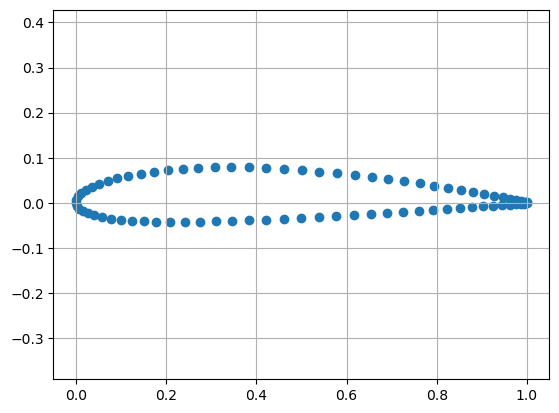

In [14]:
plt.scatter(airfoil_x, airfoil_y)
plt.axis('equal') # заставляем использовать равные пропорции осей
plt.grid(True) # риусуем сетку

Профиль описывается с помощью так называемой линии прогиба (camber) и толщины (thickness).

Прогиб (camber) описывается зависимостью
$$
y_c = 
\left\{
\begin{array}{ll}
\displaystyle\frac{M}{p^2}\left(2 p x - x^2\right), & 0 \leq x \leq p, \\
\displaystyle\frac{M}{(1-p)^2} \left(
1 - 2 p + 2 p x -x^2
\right), & p < x \leq 1\\
\end{array}
\right.
$$
где $x=p$ 	&ndash; точка экстремума; $M$ &ndash; коэффициент масштаба.

Распределение толщины (thickness) описывается зависимостью
$$
y_t = \frac{T}{0,2}(a_0 x^{0,5} + a_1 x + a_2 x^2 + a_3 x^3 + a_4 x^4),
$$
где $T$ &ndash; коэффициент масштаба; $a_i$ &ndash; неизвестные коэффициенты ($i=0,\ldots,4$).

Немного отойдем от официального подхода, и будем искать координаты верхней линии профиля в виде 
$$
(x, y_c(x)+y_t(x)),\quad
0 \leq x \leq 1,
$$
а нижней в виде 
$$
(x, y_c(x)-y_t(x)),\quad
0 \leq x \leq 1.
$$

При данном подходе у нас имеется `8` неизвестных параметров $p$, $M$, $T$, $a_0$, $a_1$, $a_2$, $a_3$, $a_4$. Будем искать их с помощью загруженных данных профиля. Для этого нам необходимо запрограммировать эти зависимости.
Ниже в функциях необходимо, чтобы функции были заданы в векторном виде, т.е. можно было передать несколько значений переменной `x` в виде массива, и ответ также получить с помощью массива `ndarray`.

In [17]:
def foil_thickness(x, a0, a1, a2, a3, a4, T): # половина толщины нашего профиля
    return T / 0.2 * (
            a0 * x**0.5 +
            a1 * x +
            a2 * x**2 + 
            a3 * x**3 + 
            a4 * x**4)

def foil_camber(x, p, M): # линия прогиба (camber)
    left_x = x <= p
    right_x = x > p

    res = np.empty_like(x)
    res[left_x] = M/p**2*(2*p*x[left_x] - x[left_x]**2)
    res[right_x] = M/(1-p)**2*(1-2*p+2*p*x[right_x]-x[right_x]**2)              

    return res

In [43]:
assert isinstance(foil_thickness(np.array([1,2]),0,0,0,0,0,0), np.ndarray), "foil_thickness должен выдавать массив np.ndarray"
assert foil_thickness(np.array([1,2]),0,0,0,0,0,0).shape == (2,), "размер вывода должен совпадать с размером входа"

In [51]:
# Тестируем foil_thickness
thickness_test_params = [
    [np.array([0,1,4,9]), 1,1,1,1,1,2],
    [np.array([0,1,4,9]), 1,0,0,0,0,2],
    [np.array([0,1,4,9]), 0,2,0,0,0,2],
    [np.array([0,1,4,9]), 0,0,3,0,0,2],
    [np.array([0,1,4,9]), 0,0,0,4,1,2],
    [np.array([0,1,4,9]), 0,0,0,0,5,2],
]
thickness_gt =  [
    [0.000e+00, 5.000e+01, 3.420e+03, 7.383e+04],
    [0., 10., 20.,    30.],
    [0., 20., 80.,   180.],
    [0., 30., 480., 2430.],
    [0.000e+00, 5.000e+01, 5.120e+03, 9.477e+04],
    [0.0000e+00, 5.0000e+01, 1.2800e+04, 3.2805e+05]  
]
for p, a in zip(thickness_test_params,thickness_gt):
    assert np.allclose(foil_thickness(p[0], *p[1:]), a), "Ответ неверный"

In [55]:
# Тестируем foil_camber
assert isinstance(foil_camber(np.array([1,2]),0.5,0), np.ndarray), "foil_camber должен выдавать массив np.ndarray"
assert foil_camber(np.array([1,2]),0.5,0).shape == (2,), "размер вывода должен совпадать с размером входа"

Используя написанные функции, составим выражения для координат верхней и нижней линий профиля (см. параметризацию выше). Можно использовать классические функции `python`, а можно использовать `lambda`-функции (с ними запись выглядит компактнее).

In [59]:
# Аналитическое выражение для координт верхней поверхности профиля
upper_profile = lambda x, p, M, a0, a1, a2, a3, a4, T: \
    foil_camber(x, p, M)  + foil_thickness(x, a0, a1, a2, a3, a4, T)

# Аналитическое выражение для координт нижней поверхности профиля
lower_profile = lambda x, p, M, a0, a1, a2, a3, a4, T: \
    foil_camber(x, p, M)  - foil_thickness(x, a0, a1, a2, a3, a4, T)

Для подбора параметров будем использовать функцию `scipy.optimize.minimize` (документацию можно посмотреть... ну вы поняли)). Для этого необходимо задать минимизирующий функционал, т.е. такую неотрицательную функцию, которая будет принимать минимальное значение при правильных параметрах профиля $p$, $M$, $T$, $a_0$, $a_1$, $a_2$, $a_3$, $a_4$ при подстановке в неё координат профиля (в нашем случае, полученных с сайта).

Будем рассматривать следующий функционал
$$
f(x, p, M, T, a_0, a_1, a_2, a_3, a_4) = 
\sum_{i=1}^{N_u} (upper\_profile(x_{u,i}, p, M, T, a_0, a_1, a_2, a_3, a_4)-y_{u,i})^2 +
\sum_{i=1}^{N_l} (lower\_profile(x_{l,i}, p, M, T, a_0, a_1, a_2, a_3, a_4)-y_{l,i})^2,
$$
где $N_u$ &ndash; количество точек, задающих верхнюю линию профиля; 
$(x_{u,i}, y_{u,i})$ &ndash; коодинаты точек верхней линии профиля ($i=1,\ldots,N_u$);
$N_l$ &ndash; количество точек, задающих нижнюю линию профиля; 
$(x_{l,i}, y_{l,i})$ &ndash; коодинаты точек верхней линии профиля ($i=1,\ldots,N_l$).




Параметры будем хранить в массиве `params` в следующем порядке $(p, M, a_0, a_1, a_2, a_3, a_4, T)$ и передавать их наш функционал в таком виде.

Для того, чтобы при обращении к функции `upper_profile` не писать каждый раз
```python
upper_profile(
    x, 
    params[0], 
    params[1], 
    params[2], 
    params[3], 
    params[4], 
    params[5], 
    params[6], 
    params[7]
)
```
можно использовать оператор разыменовывания `*`. 

Тогда тоже самое можно написать короче `upper_profile(x, *params)`.

In [60]:
# Координаты верхней части профиля из загруженных данных
upper_surface_x = airfoil_data[:41, 0]
upper_surface_y = airfoil_data[:41, 1]

# Координаты нижней части профиля из загруженных данных
lower_surface_x = airfoil_data[41:, 0]
lower_surface_y = airfoil_data[41:, 1]

# Минимизируемый функционал для нахождения параметров профиля
func = lambda params: \
    np.sum((upper_profile(upper_surface_x, *params) - upper_surface_y)**2) + \
    np.sum((lower_profile(lower_surface_x, *params) - lower_surface_y)**2)


Используя `func` в качестве минимизируемого функционала найдем оптимальные параметры с помощью функции `minimize`. В качестве начального приближения можно использовать вектор, задающий следующие значения искомых параметров, `(0.1, 0.1, 1, 1, 1, 1, 1, 1)`.

In [61]:
res = minimize(func, (0.1, 0.1, 1, 1, 1, 1, 1, 1))
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.8600346005428055e-05
        x: [ 3.910e-01  2.018e-02  2.635e+01 -1.742e+01 -1.061e+01
            -1.795e-01  2.082e+00  1.446e-03]
      nit: 83
      jac: [ 4.219e-07  2.956e-06 -3.340e-07 -6.744e-07  3.853e-07
            -3.546e-07 -7.740e-08  4.513e-06]
 hess_inv: [[ 3.798e+01  1.978e-02 ... -2.283e+00 -2.381e-04]
            [ 1.978e-02  1.662e-02 ...  2.235e-01  8.101e-06]
            ...
            [-2.283e+00  2.235e-01 ...  1.047e+04 -2.702e-02]
            [-2.381e-04  8.101e-06 ... -2.702e-02  4.188e-05]]
     nfev: 1044
     njev: 116

Если оптимизация завершилась успешно (о чем говорит поле `res.message`), то оптимальные параметры будут храниться в `res.x`

In [171]:
assert res.success, "Кажется, что-то пошло не так!"
print("Вероятно, оптимизация прошла успешно!")

Вероятно, оптимизация прошла успешно!


In [165]:
opt_profile_params = res.x
param_name = ['p', 'M', 'a_0', 'a_1', 'a_2', 'a_3', 'a_4', 'T']

for p_name, p in zip(param_name, opt_profile_params):
    display(Math(f"{p_name} = {p}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Нарисуем линии профиля, используя полученные параметры, поверх облака данных. Если всё правильно, то они совпадут.

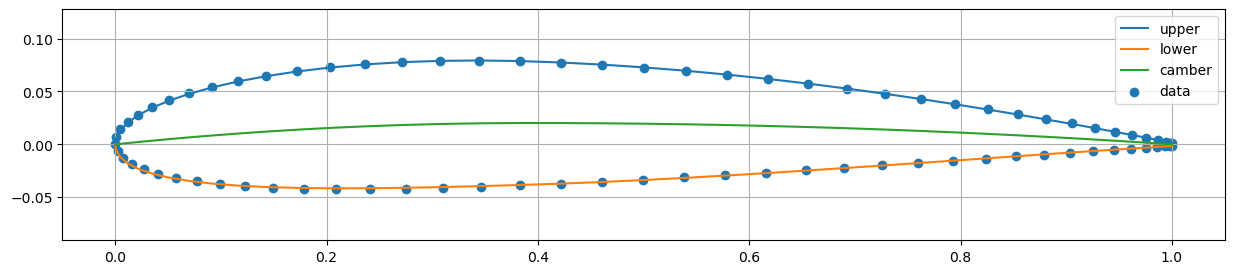

In [166]:
fig, ax = plt.subplots(figsize=(15,3))

ax.plot(upper_surface_x, upper_profile(upper_surface_x, *opt_profile_params), label='upper')
ax.plot(upper_surface_x, lower_profile(upper_surface_x, *opt_profile_params), label='lower')
ax.plot(upper_surface_x, foil_camber(upper_surface_x, opt_profile_params[0], opt_profile_params[1]), label='camber')

ax.axis('equal')
ax.scatter(airfoil_x, airfoil_y, label='data')
ax.grid(True)
ax.legend(loc='best');

## Генерация профиля

Нашей целью будет научиться генерировать облако точек соответствующего профиля с заданной геометрией.

Сейчас профиль находиться на плоскости в прямоугольнике $0 \leq x \leq 1$, $-0,05 < y < 0,10$. Самое простое преобразование &ndash; это смещение (параллельный перенос), которому математически отвечает следующее преобразование
$$
\left\{
\begin{array}{l}
x' = x + a, \\
y' = y + b, \\
\end{array}
\right.
$$
где $(x,y)$ &ndash; старые координаты точки; $(x', y')$  &ndash;  новые координаты точки; $(a,b)$ &ndash; вектор, на которые происходит смещение.



Напишем функцию, которая смещает заданное облако точек на вектор $(a,b)$.

Будем использовать такой механизм, который называется `broadcasting` (https://numpy.org/doc/stable/user/basics.broadcasting.html). 
Основная его идея состоит в том, чтобы для того чтобы выполнить операцию между двумя массивами мы должны их привести к правильным размерностям.

Так облако точек имеет размерность `(N, 2)` (пример, `X = np.array([[1,2],[3,4]])`, а вектор смещения имеет размерность `(2,)` (пример, `y = np.array([0,1])`. 
Мы не можем просто написать `X+y`, это будет некорректно. Broadcasting позволяет привести массив `y` к размерности `(1,2)` с помощью выражения `None`. Выражение вида `y[None, :]` говорит добавить одно измерение массиву `y`, а все данные, первого измерения, расположить вдоль второго измерения.  Таким образом, в нашем случае корректно будет написать `X+y[None, :]`, что соответствует массиву, в котором к каждой координате из `X` прибавляется вектор `y`. Что нам и требовалось.

In [81]:
def translation(coords, delta):
    # coords -- двумерный массив -- набор координат точек
    # delta -- вектор смещения
    return coords + delta[None, :]

Сместим профиль крыла на вектор $(1, 2)$.

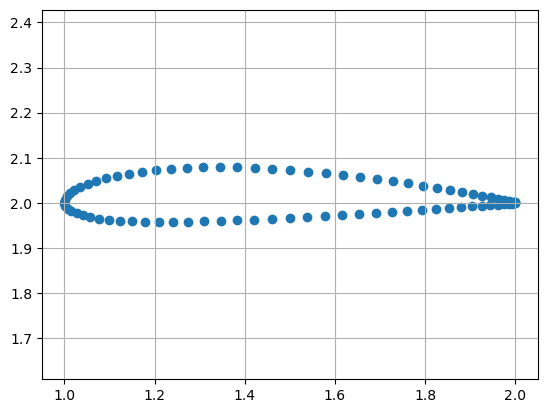

In [111]:
def extract_xy(coords):
    return coords[:, 0], coords[:, 1]

transl_airfoil_data = translation(airfoil_data, np.array(([1,2])))

plt.axis('equal')
plt.scatter(*extract_xy(transl_airfoil_data), label='data')
plt.grid(True)

Преобразование поворота по часовой стрелке на угол $\varphi$ относительно начала координат описывается следующей матрицей
$$
Q(\varphi) = 
\begin{pmatrix}
\cos\varphi & \sin\varphi \\
-\sin\varphi & \cos\varphi \\
\end{pmatrix},
$$
а само преобразование имеет вид
$$
\begin{pmatrix}
x'\\
y'\\
\end{pmatrix} = 
\begin{pmatrix}
\cos\varphi & \sin\varphi \\
-\sin\varphi & \cos\varphi \\
\end{pmatrix}
\begin{pmatrix}
x\\
y\\
\end{pmatrix},
$$
где $(x,y)$ &ndash; старые координаты точки; $(x', y')$  &ndash;  новые координаты точки, после поворота.

Сгенерируем матрицу поворота

In [112]:
def Q(phi):
    return np.array([
        [np.cos(phi), np.sin(phi)],
        [-np.sin(phi), np.cos(phi)],
    ])

Напишем функцию, которая поворачивает заданное облако точек относительно заданной точки. Такое преобразование имеет вид
$$
\begin{pmatrix}
x'\\
y'\\
\end{pmatrix} = 
\begin{pmatrix}
\cos\varphi & \sin\varphi \\
-\sin\varphi & \cos\varphi \\
\end{pmatrix}
\begin{pmatrix}
x-x_0\\
y-y_0\\
\end{pmatrix} + 
\begin{pmatrix}
x_0\\
y_0\\
\end{pmatrix},
$$
где $(x,y)$ &ndash; старые координаты точки; $(x', y')$  &ndash;  новые координаты точки, после поворота; $(x_0, y_0)$ -- координаты точки, относительно которой совершается поворот.

In [113]:
def rotate(coords, phi, point):
    # coords -- координаты облака точек
    # phi -- угол поворота (положительное phi должно соответствовать повороту против часовой стрелки)
    # point -- координаты точки, относительно которой будет осуществляться поворот
    return (coords - point[None,:]) @ Q(phi) + point[None,:]
    

Повернем профиль против часовой стрелки на угол $-\pi/6$ относительно точки $(0.5, 0)$.

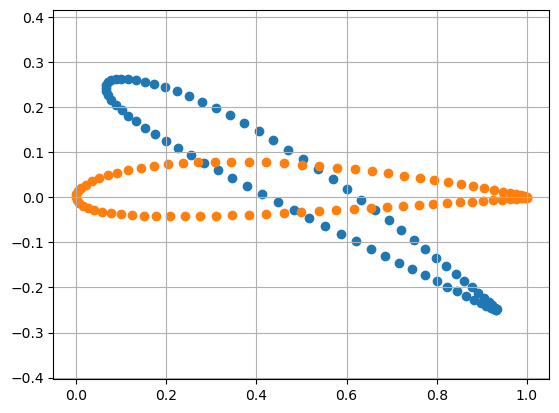

In [115]:
rot_airfoil_data = rotate(airfoil_data, -np.pi/6, np.array(([0.5, 0.])))

plt.axis('equal')
plt.scatter(*extract_xy(rot_airfoil_data), label='rot')
plt.scatter(airfoil_x, airfoil_y, label='src')

plt.grid(True)

По аналогии напишем функцию, которая растягивает заданное облако точек относительно заданной точки в $\lambda_x$ раз по оси $x$ и $\lambda_y$ раз по оси $y$. Такое преобразование имеет вид
$$
\begin{pmatrix}
x'\\
y'\\
\end{pmatrix} = 
\begin{pmatrix}
\lambda_x & 0 \\
0 & \lambda_y \\
\end{pmatrix}
\begin{pmatrix}
x-x_0\\
y-y_0\\
\end{pmatrix} + 
\begin{pmatrix}
x_0\\
y_0\\
\end{pmatrix},
$$
где $(x,y)$ &ndash; старые координаты точки; $(x', y')$  &ndash;  новые координаты точки, после растяжения; $(x_0, y_0)$ -- координаты точки, относительно которой совершается поворот.

In [121]:
def scale(coords, lambdax, lambday, point):
    # coords -- координаты облака точек
    # phi -- угол поворота (положительное phi должно соответствовать повороту против часовой стрелки)
    # point -- координаты точки, относительно которой будет осуществляться поворот
    
    return (coords - point[None,:]) * np.array([[lambdax, lambday]]) + point[None,:]

Совершим растяжение нашего профиля вдоль оси $x$ в $1.5$ раза, а вдоль оси $y$ в $2.0$ раза относительно точки $(0.5, 0)$.

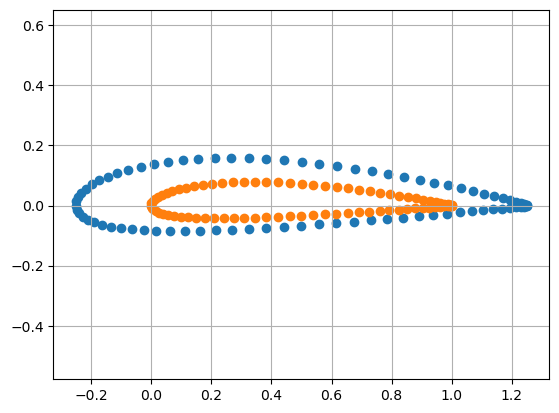

In [122]:
scale_airfoil_data = scale(airfoil_data, 1.5, 2, np.array(([0.5, 0.])))

plt.axis('equal')
plt.scatter(*extract_xy(scale_airfoil_data), label='rot')
plt.scatter(airfoil_x, airfoil_y, label='src')

plt.grid(True)

Напишем функцию, которая генерирует облако точек для нашего профиля с учетом поворота и растяжения, относительно геометрического центра.

In [169]:
def generate_profile(N, params, phi = 0, scale_factor = [1.0, 1.0]):
    """Функция генерации облака точек для профиля
    @param N int: количество точек в верхней линии
    @param params tuple[float, float, float, float, float, float, float, float]: значения параметров для вычисления профиля
    @param phi float: угол поворота против часовой стрелки относительно геометрического центра облака точек
    @param scale_factor tuple[double, double]: коэффициенты растяжения относительно геометрического центра облака точек
    
    @return np.ndarray((2*N-2, 2)): облако координат 
    """
    # Генерируем равномерно распределенные точки на отрезке [0, \pi]
    beta = np.linspace(0, np.pi, num = N) 

    # Переводим beta в точки на отрезке [0,1], сгущая распределение к концам отрезка [0,1]
    x = (1.0 - np.cos(beta))/2.

    # print(x[1:]
    
    data = np.empty((2*N-2, 2), dtype=float)
    data[:N, 0] = x
    data[N:, 0] = np.flip(x[1:-1])
    data[:N, 1] = upper_profile(x, *params)
    data[N:, 1] = lower_profile(data[N:, 0], *params)

    center = np.average(data, axis=0)

    # Генерируем облако, сначала растяжение, а потом поворот
    return rotate(scale(data, *scale_factor, center), phi, center) 

Нарисуем профиль, сотоящий из 158 точек, повернутый на угол $\pi/10$ против часовой стрелки и растянутый по оси $x$  в два раза.

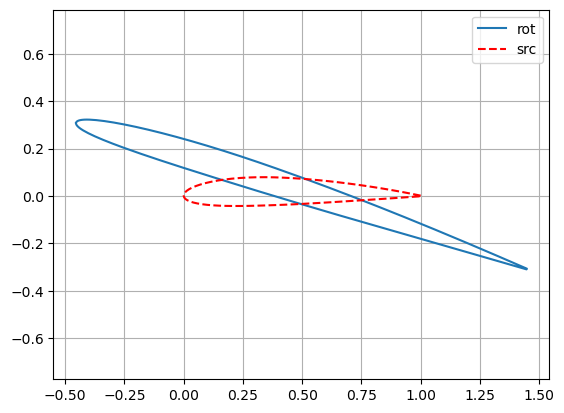

In [170]:
plt.axis('equal')
plt.plot(
    *extract_xy(
        generate_profile(80, opt_profile_params, 
            phi = -np.pi/10, scale_factor=[2,1]
        )
    ), 
    label='rot'
)
plt.plot(airfoil_x, airfoil_y, 'r--', label='src')

plt.grid(True)

plt.legend(loc='best')